## Import the necessary library


In [2]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Method to plot the progress of the agent's score

In [4]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Validation method
The noise has to be deactivated before the validation. This method is being used to assess the performance of the agent after every episode of training

In [5]:
def validate(agent, max_t, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    agent.reset()
    states = env_info.vector_observations
    scores_one_episode = np.zeros(states.shape[0])
    for t in range(max_t):
        actions = agent.act(states, add_noise=False)             # select an action (for each agent)
        env_info = env.step(actions)[brain_name]                 # send all actions to the environment
        next_states = env_info.vector_observations               # get next state (for each agent)
        rewards = env_info.rewards                               # get reward (for each agent)
        dones = env_info.local_done                              # see if episode finished
        scores_one_episode += env_info.rewards                   # update the score (for each agent)
        states = next_states                                     # roll over states to next time step
        if np.any(dones):                                        # exit loop if episode finished
            break
    return scores_one_episode

## Training method
The main loop of the training can be found here

In [10]:
def train(agent, n_episodes=500, max_t=500, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)              # select an action (for each agent)
            env_info = env.step(actions)[brain_name]                 # send all actions to the environment
            next_states = env_info.vector_observations               # get next state (for each agent)
            rewards = env_info.rewards                               # get reward (for each agent)
            dones = env_info.local_done                              # see if episode finished
            agent.step(states, actions, rewards, next_states, dones) # learn
            states = next_states                                     # roll over states to next time step
            if np.any(dones):                                        # exit loop if episode finished
                break
        scores_one_episode = validate(agent, max_t, train_mode=train_mode)
        score = np.average(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.3f}\tLast Score: {:.3f}\tMax Score: {:.3f}'.format(i_episode, 
                                                                                          mean_100, 
                                                                                          score,
                                                                                         np.max(scores_one_episode)), end="")
        if i_episode % 100 == 0:
            print(' '*300, end="")
            print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}'.format(i_episode, mean_100, np.max(scores_window)))
            agent.save()
        if len(scores_window) >= 100 and np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save()
            break
    return scores

## Prepare the agent
* One instance of the memory ReplayBuffer is built here
* The ParallelDDPG is one version of the DDPG that use one local actor/critic network and one target actor/critic network that are being used by several agents
* The hyperparameters are set and the agent is initialized
* Several instances of the noise generator are created and attached to the agent

In [7]:
from agents.utils import ReplayBuffer, ParameterNoise, ActionNoise
from agents.parallel_ddpg import ParallelDDPG
from agents.models_success import Actor, Critic
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
torch.set_num_threads(3)
random_seed = 0
states = env_info.vector_observations
action_size = brain.vector_action_space_size
memory = ReplayBuffer(action_size, device, int(1e5), 64, random_seed)
agent = ParallelDDPG(states.shape[1], action_size, random_seed, states.shape[0], memory, Actor, Critic, device, 
                    TAU=1e-3,
                    UPDATE_EVERY=20,
                    TRANSFER_EVERY=1,
                    UPDATE_LOOP=10,
                    ADD_NOISE_EVERY=1,
                    BOOTSTRAP_SIZE=4,
                    LR_CRITIC = 1e-4,
                    LR_ACTOR = 1e-3)
# noise = ParameterNoise(agent.actor_target, device, random_seed, mu=0., theta=0.3, sigma=0.05)

random.seed(random_seed)
noise = [ActionNoise(action_size, device, random_seed + i*10, mu=-0.5, theta=0.1*random.random(), 
                     sigma=0.1*random.random()) for i in range(int(states.shape[1]))] 
agent.set_noise(noise)
# Check that saving and loading are working
# agent.save()
# agent.load()

## Start training

Episode 100	Average Score: 0.350	Max Score: 1.0090	Max Score: 1.690                                                                                                                                                                                                                                                                                                            
Episode 200	Average Score: 1.189	Max Score: 2.1735	Max Score: 5.420                                                                                                                                                                                                                                                                                                            
Episode 300	Average Score: 2.202	Max Score: 3.0753	Max Score: 4.480                                                                                                                                                                                                     

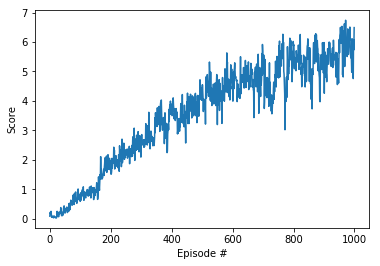

In [8]:
scores = train(agent, n_episodes=1000, max_t=200, train_mode=True)
plot_result(scores)

# Load the latest weight and continue the training

In [ ]:
agent.load("/weights/1300")
scores = train(agent, n_episodes=1000, max_t=200, train_mode=True)
plot_result(scores)

Episode 100	Average Score: 6.297	Max Score: 7.3460	Max Score: 7.650                                                                                                                                                                                                                                                                                                            
Episode 200	Average Score: 6.662	Max Score: 7.2922	Max Score: 7.540                                                                                                                                                                                                                                                                                                            
Episode 300	Average Score: 6.604	Max Score: 7.4004	Max Score: 7.640                                                                                                                                                                                                     

In [ ]:
agent.load("/weights/1900")
scores = train(agent, n_episodes=1000, max_t=200, train_mode=True)
plot_result(scores)

## Final round
The previous training was restricted to 200 timesteps for each episode. The maximum timestep for this environment is 1,000 timestep. The next code is to demonstrate that the agent is able to solve the environment with less timestep (900). It is capable of reaching an average of +30 per agent per 100 for the last 100 episodes.
This performance can still be pushed.

Episode 100	Average Score: 32.401	Max Score: 35.1577	Max Score: 35.040                                                                                                                                                                                                                                                                                                            

Environment solved in 100 episodes!	Average Score: 32.401


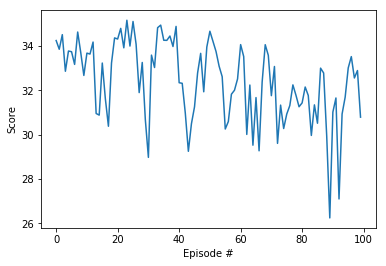

In [11]:
agent.load("/weights/2100")
scores = train(agent, n_episodes=1000, max_t=900, train_mode=True)
plot_result(scores)